In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.dish_bin.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *
from spatial_scene_grammars.dataset import *

import meshcat
import meshcat.geometry as meshcat_geom

Generating from folder  sink/plates_cups_and_bowls/plates
sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring :  <class 'spatial_scene_grammars_examples.dish_bin.grammar.sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring'>
sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado :  <class 'spatial_scene_grammars_examples.dish_bin.grammar.sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado'>
sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise :  <class 'spatial_scene_grammars_examples.dish_bin.grammar.sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise'>
sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise :  <class 'spatial_scene_grammars_examples.dish_bin.grammar.sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise'>
Generating from folder  sink/plates_cups_and_bowls/cups
sink:plates_cups_and_bowls:cups:Cole_Hardware_Mug_Classic_Blue :  <class '

In [2]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()
vis.delete()
base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
'''
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))
'''

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7009/static/
Meshcat url:  http://127.0.0.1:7009/static/


'\nfrom IPython.display import HTML\nHTML("""\n    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">\n    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>\n</div>\n""".format(url=meshcat_url))\n'

In [3]:
# Convert dataset to observed node sets (caching output) and draw a few examples.

RECONVERT_DATASET = True
DATASET_YAML_FILE = "sink/saved_scenes.yaml"
DATASET_SAVE_FILE = "observed_node_sets.dat"

if RECONVERT_DATASET or not os.path.exists(DATASET_SAVE_FILE):
    type_map = {
        "bin": DishBin
    }
    model_map = {
    }
    for model_type_set in [PlateModels, CupModels, BowlModels]:
        for model_type in model_type_set:
            # Have to cut off the "sink" folder to match model names;
            # dataset management is ugly and should get reorganized...
            model_map[os.path.join(*model_type.sdf.split("/")[1:])] = model_type
    observed_node_sets = convert_scenes_yaml_to_observed_nodes(DATASET_YAML_FILE, type_map, model_map)
    print("Saving...")
    with open(DATASET_SAVE_FILE, "wb") as f:
        pickle.dump(observed_node_sets, f)

print("Loading...")
with open(DATASET_SAVE_FILE, "rb") as f:
    observed_node_sets = pickle.load(f)

draw_scene_tree_contents_meshcat(
    SceneTree.make_from_observed_nodes(observed_node_sets[0]),
    zmq_url=vis.window.zmq_url, prefix="observed/contents"
)

[2021-10-01 01:11:35.324] [console] [warning] FindResource ignoring DRAKE_RESOURCE_ROOT='/home/gizatt/drake' because it does not contain a 'drake' subdirectory.


Saving...
Loading...


In [4]:
total_of_each_type = {"DishBin": 0}
for model_type_set in [PlateModels, CupModels, BowlModels]:
    for model_type in model_type_set:
        total_of_each_type[model_type.__name__] = 0
for observed_nodes in observed_node_sets:
    for node in observed_nodes:
        total_of_each_type[type(node).__name__] += 1
print(total_of_each_type)

{'DishBin': 30, 'sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring': 12, 'sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado': 12, 'sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise': 21, 'sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise': 0, 'sink:plates_cups_and_bowls:cups:Cole_Hardware_Mug_Classic_Blue': 12, 'sink:plates_cups_and_bowls:cups:Room_Essentials_Mug_White_Yellow': 12, 'sink:plates_cups_and_bowls:cups:Threshold_Porcelain_Coffee_Mug_All_Over_Bead_White': 14, 'sink:plates_cups_and_bowls:bowls:Bradshaw_International_11642_7_Qt_MP_Plastic_Bowl': 9, 'sink:plates_cups_and_bowls:bowls:Cole_Hardware_Bowl_Scirocco_YellowBlue': 10, 'sink:plates_cups_and_bowls:bowls:Room_Essentials_Bowl_Turquiose': 8}


In [5]:
# Draw a random sample from the grammar with its initial params and visualize it.
#torch.random.manual_seed(5)

grammar = SpatialSceneGrammar(
    root_node_type = DishBin,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.5, 0., 0.]))
)

tree = grammar.sample_tree(detach=True)
observed_nodes = tree.get_observed_nodes()

vis["sample"].delete()
draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="sample/contents")
draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="sample/structure")

In [6]:
observed_node_set_test = [
    BowlModels[0](drake_tf_to_torch_tf(RigidTransform(
        p=[0.5, 0.0, 0.1],
        R=UniformlyRandomRotationMatrix(RandomGenerator(0))))
    ),
    DishBin(drake_tf_to_torch_tf(
        RigidTransform(p=[0.5, 0., 0.]))
    )
]
print([type(node).__name__ for node in observed_node_set_test])

['sink:plates_cups_and_bowls:bowls:Bradshaw_International_11642_7_Qt_MP_Plastic_Bowl', 'DishBin']


In [7]:
supertree = grammar.make_super_tree(max_recursion_depth=10)
print("Supertree size ", len(supertree.nodes))

Supertree size  202


In [9]:
# Parse that dummy observation; it should have only one unique parse, since there's only one
# object.
trees = get_optimized_trees_from_mip_results(infer_mle_tree_with_mip(grammar, observed_node_sets[1], N_solutions=5, max_recursion_depth=10, verbose=True))
vis["parses"].delete()
draw_scene_tree_contents_meshcat(trees[0], zmq_url=vis.window.zmq_url, prefix="parses/contents")
for k, tree in enumerate(trees):
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="parses/structure/%d" % k)

Starting setup.
Activation vars allocated.
Continuous variables allocated.
Setup time:  0.4110753536224365
Num vars:  3011
Num constraints:  6395
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Fri Oct  1 01:18:31 2021

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 4210 rows, 3011 columns and 17618 nonzeros
Model fingerprint: 0x9bdfd3fc
Model has 213 quadratic objective terms
Variable types: 2754 continuous, 257 integer (257 binary)
Coefficient statistics:
  Matrix range     [1e-13, 1e+04]
  Objective range  [2e-01, 6e+01]
  QObjective range [2e+01, 3e+03]
  Bounds range     [1e-01, 1e+00]
  RHS range        [1e+00, 1e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 3493 rows and 2370 columns
Presolve time: 0.02s
Presolved: 717 rows, 641 columns, 3131 nonzeros
Presolved model has 132 quadratic objective terms
Variable types: 630 continuous, 11

In [ ]:
print(len(trees))

# MIPMAP-EM alternation

In [10]:
em = EMWrapper(grammar, observed_node_sets)
em.do_iterated_em_fitting(em_iterations=10, tqdm=tqdm, N_solutions=10, num_workers=10, max_recursion_depth=10)

EM Iteration:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

SpatialSceneGrammar(
  (params_by_node_type): ModuleDict(
    (Cup): ConstrainedParameter()
    (AssortedBowls): ConstrainedParameter()
    (sink:plates_cups_and_bowls:cups:Room_Essentials_Mug_White_Yellow): None
    (AssortedPlates): ConstrainedParameter()
    (PlateStack): None
    (FullBowl): None
    (sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise): None
    (Bowl): ConstrainedParameter()
    (sink:plates_cups_and_bowls:bowls:Cole_Hardware_Bowl_Scirocco_YellowBlue): None
    (sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring): None
    (sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado): None
    (DishBin): ConstrainedParameter()
    (AssortedPlateStacks): ConstrainedParameter()
    (sink:plates_cups_and_bowls:cups:Threshold_Porcelain_Coffee_Mug_All_Over_Bead_White): None
    (AssortedCups): ConstrainedParameter()
    (sink:plates_cups_and_bowls:cups:Cole_Hardware_Mug_Classic_Blue): None
    (Object): ConstrainedParamet

In [11]:
# Save our grammar params
torch.save(grammar.state_dict(), "fit_grammar.torch")

Final params:  tensor([0.5000, 0.6675, 0.3366, 0.4000, 0.3000])


Final params:  tensor([9.9990e-05, 5.8102e-01, 4.1888e-01])


Plate
Final params:  tensor([2.6664e-01, 2.6664e-01, 4.6662e-01, 9.9990e-05])
PlateStack
mean tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-2.6846e-07,  1.0372e-03,  1.1756e-02],
        [ 1.1371e-03,  1.0318e-03,  1.1738e-02],
        [ 2.3677e-03,  9.9496e-04,  1.1721e-02],
        [ 3.6328e-03,  7.4288e-04,  1.1602e-02],
        [ 4.8839e-03, -9.4033e-04,  1.0772e-02],
        [ 4.7688e-03, -6.1062e-03,  7.3988e-03],
        [ 4.5713e-06, -5.7720e-03,  2.1789e-03],
        [ 1.0597e-03, -5.2949e-03,  7.6524e-04],
        [ 1.5729e-03, -5.2959e-03,  7.6363e-04],
        [ 1.6762e-03, -5.2959e-03,  7.6363e-04]])
0:xyz:mean final: tensor([ 0.0017, -0.0053,  0.0008])
variance tensor([[5.0000e-03, 5.0000e-03, 5.0000e-03],
        [2.3876e-04, 3.7947e-04, 1.3001e-04],
        [2.4745e-04, 3.2526e-04, 1.3219e-04],
        [2.5080e-04, 3.2460e-04, 1.3211e-04],
        [2.5265e-04, 3.2445e-04, 1.3152e-04],
        [2.5804e-04, 3.2022e-04, 1.2675e-04],
        [2.8107e-04, 2.6999

AssortedPlateStacks
Final params:  tensor([0.9999])
mean tensor([[ 0.0000,  0.0000,  0.0100],
        [-0.0129,  0.0208,  0.0147],
        [-0.0140,  0.0208,  0.0147],
        [-0.0152,  0.0208,  0.0147],
        [-0.0165,  0.0208,  0.0147],
        [-0.0178,  0.0208,  0.0147],
        [-0.0190,  0.0208,  0.0147],
        [-0.0197,  0.0208,  0.0147],
        [-0.0206,  0.0208,  0.0147],
        [-0.0211,  0.0208,  0.0147],
        [-0.0212,  0.0208,  0.0147]])
0:xyz:mean final: tensor([-0.0212,  0.0208,  0.0147])
variance tensor([[5.0000e-02, 5.0000e-02, 1.0000e-03],
        [1.7419e-03, 2.2355e-02, 1.0000e-06],
        [1.6370e-03, 2.4236e-02, 1.0000e-06],
        [1.6069e-03, 2.4322e-02, 1.0000e-06],
        [1.5966e-03, 2.4324e-02, 1.0000e-06],
        [1.5929e-03, 2.4324e-02, 1.0000e-06],
        [1.5888e-03, 2.4327e-02, 1.0000e-06],
        [1.5530e-03, 2.4359e-02, 1.0000e-06],
        [1.5301e-03, 2.4313e-02, 1.0000e-06],
        [1.5426e-03, 2.4227e-02, 1.0000e-06],
        [1.6

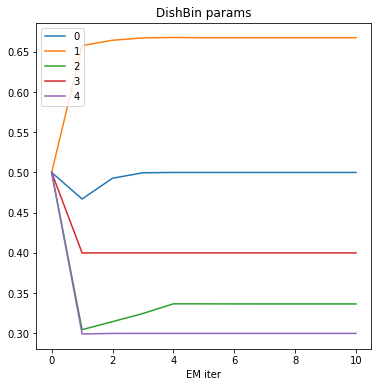

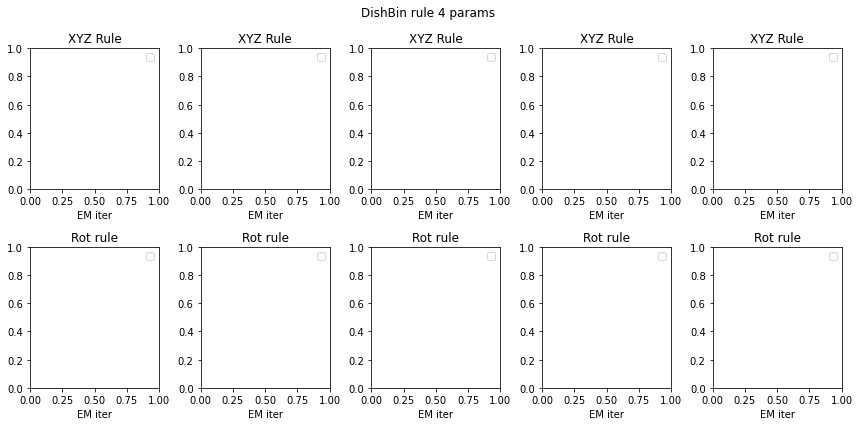

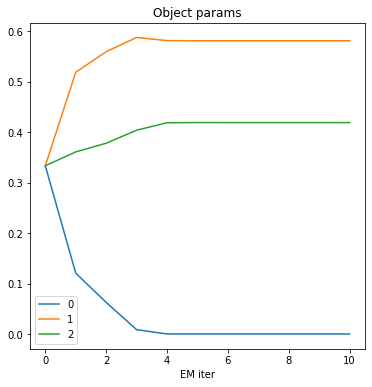

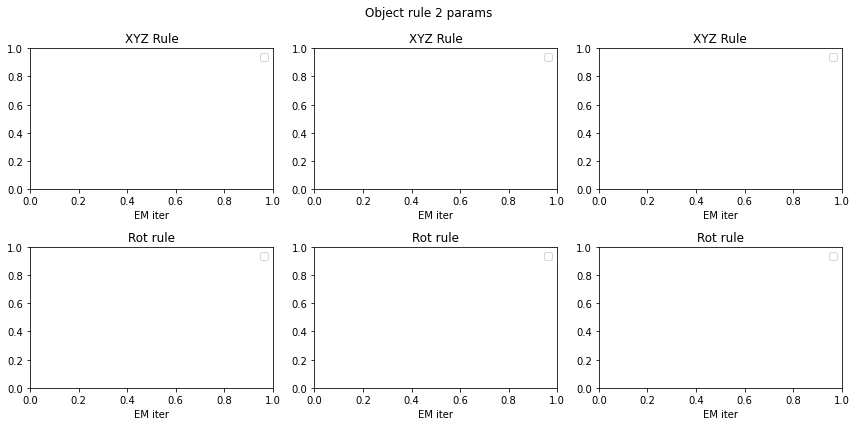

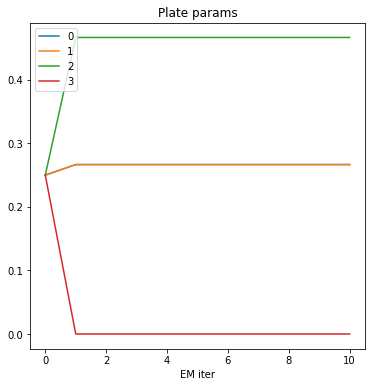

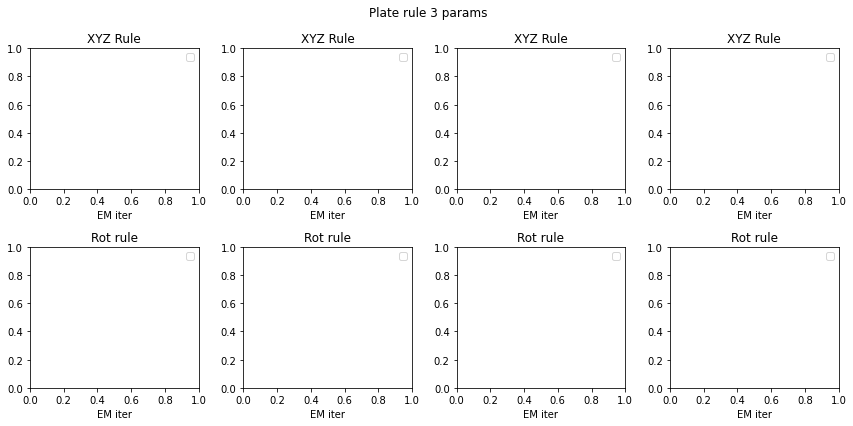

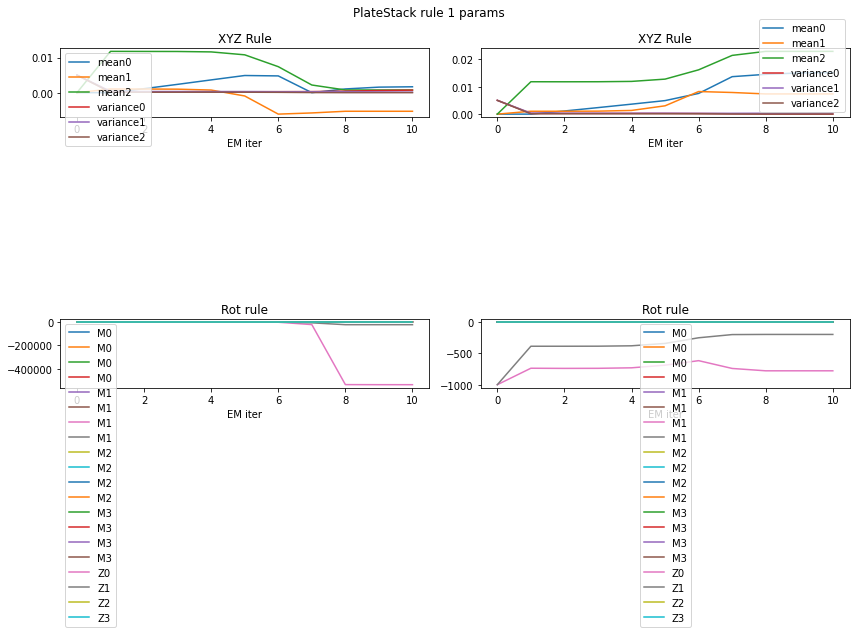

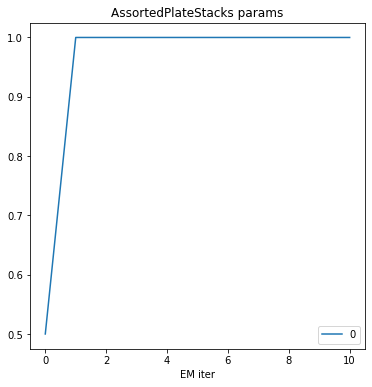

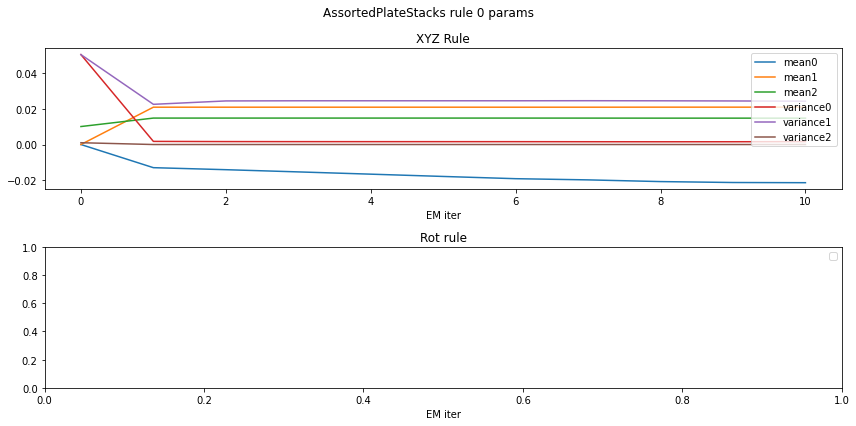

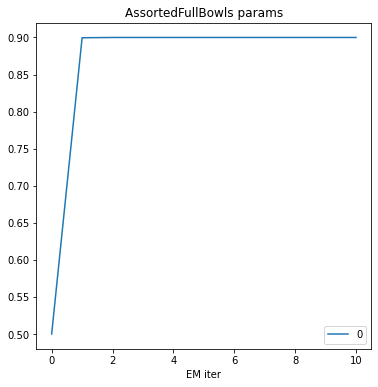

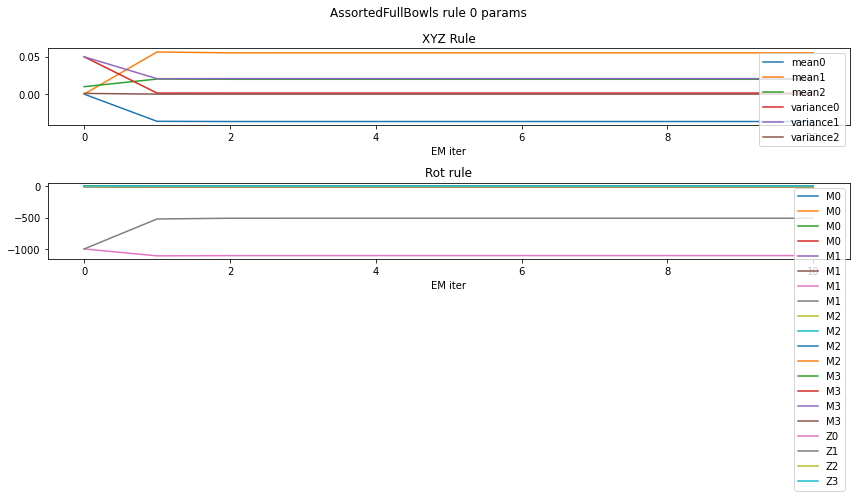

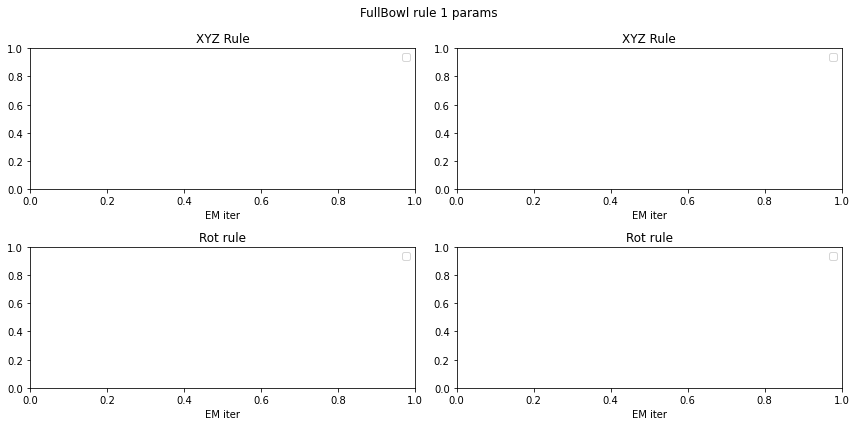

In [17]:
em.plot_grammar_parameter_history(DishBin)
em.plot_grammar_parameter_history(Object)
print("Plate")
em.plot_grammar_parameter_history(Plate)
print("PlateStack")
em.plot_grammar_parameter_history(PlateStack)
print("AssortedPlateStacks")
em.plot_grammar_parameter_history(AssortedPlateStacks)
print("AssortedFullBowls")
em.plot_grammar_parameter_history(AssortedFullBowls)
print("FullBowl")
em.plot_grammar_parameter_history(FullBowl)

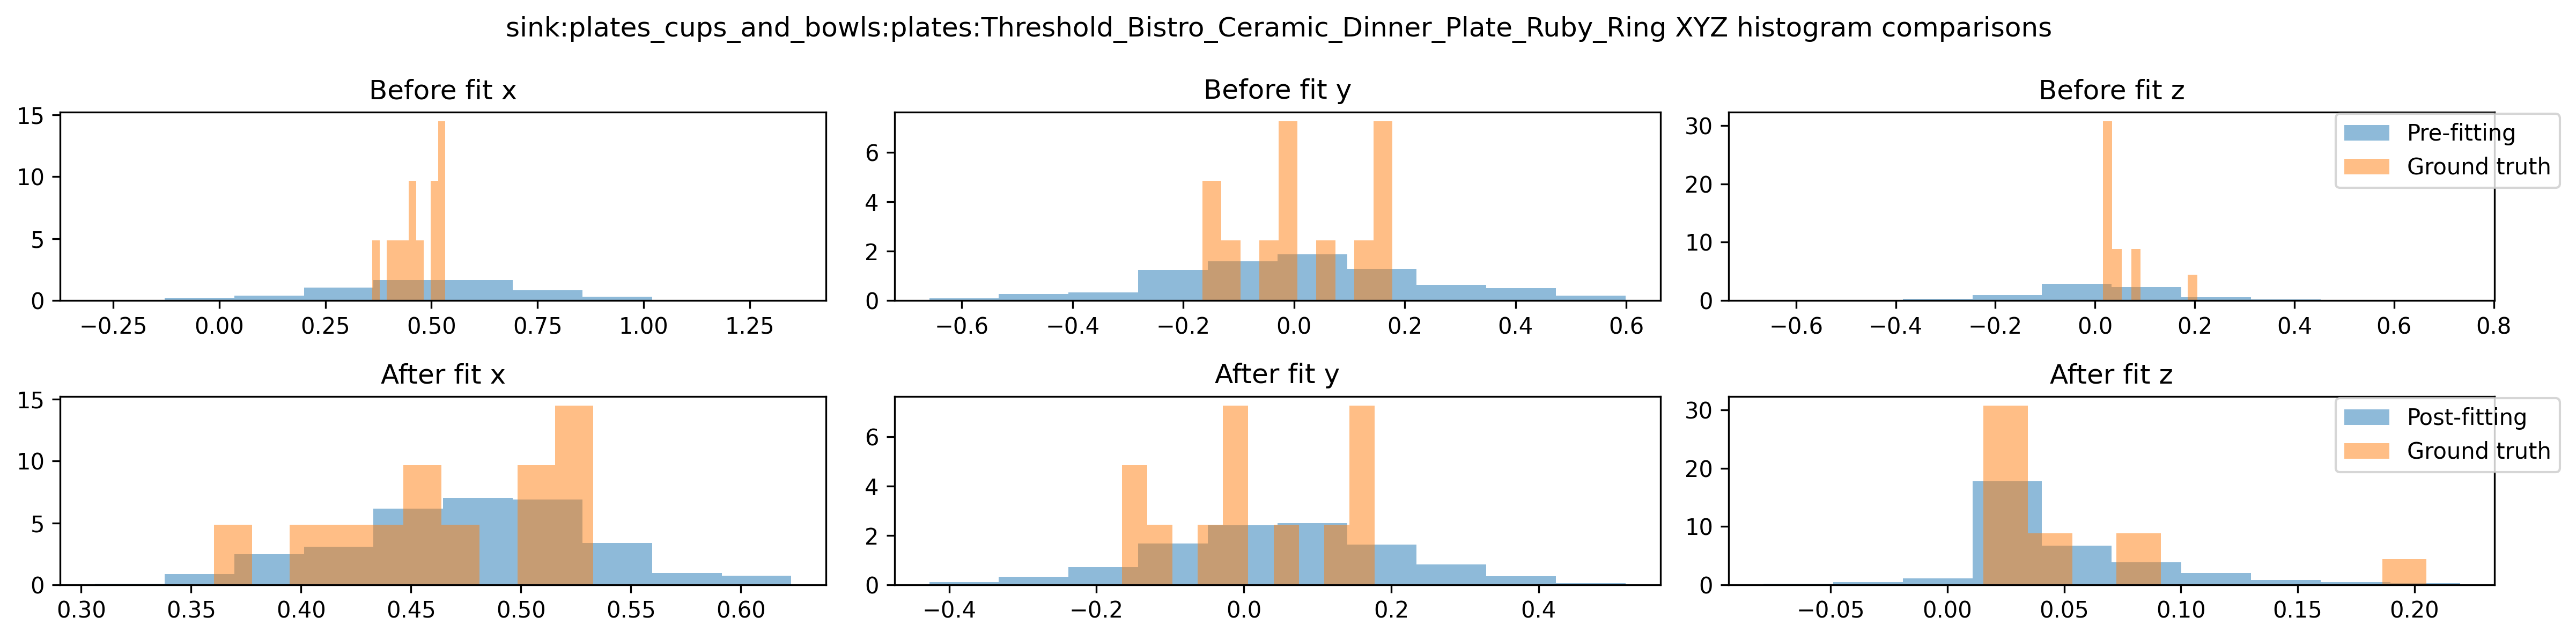

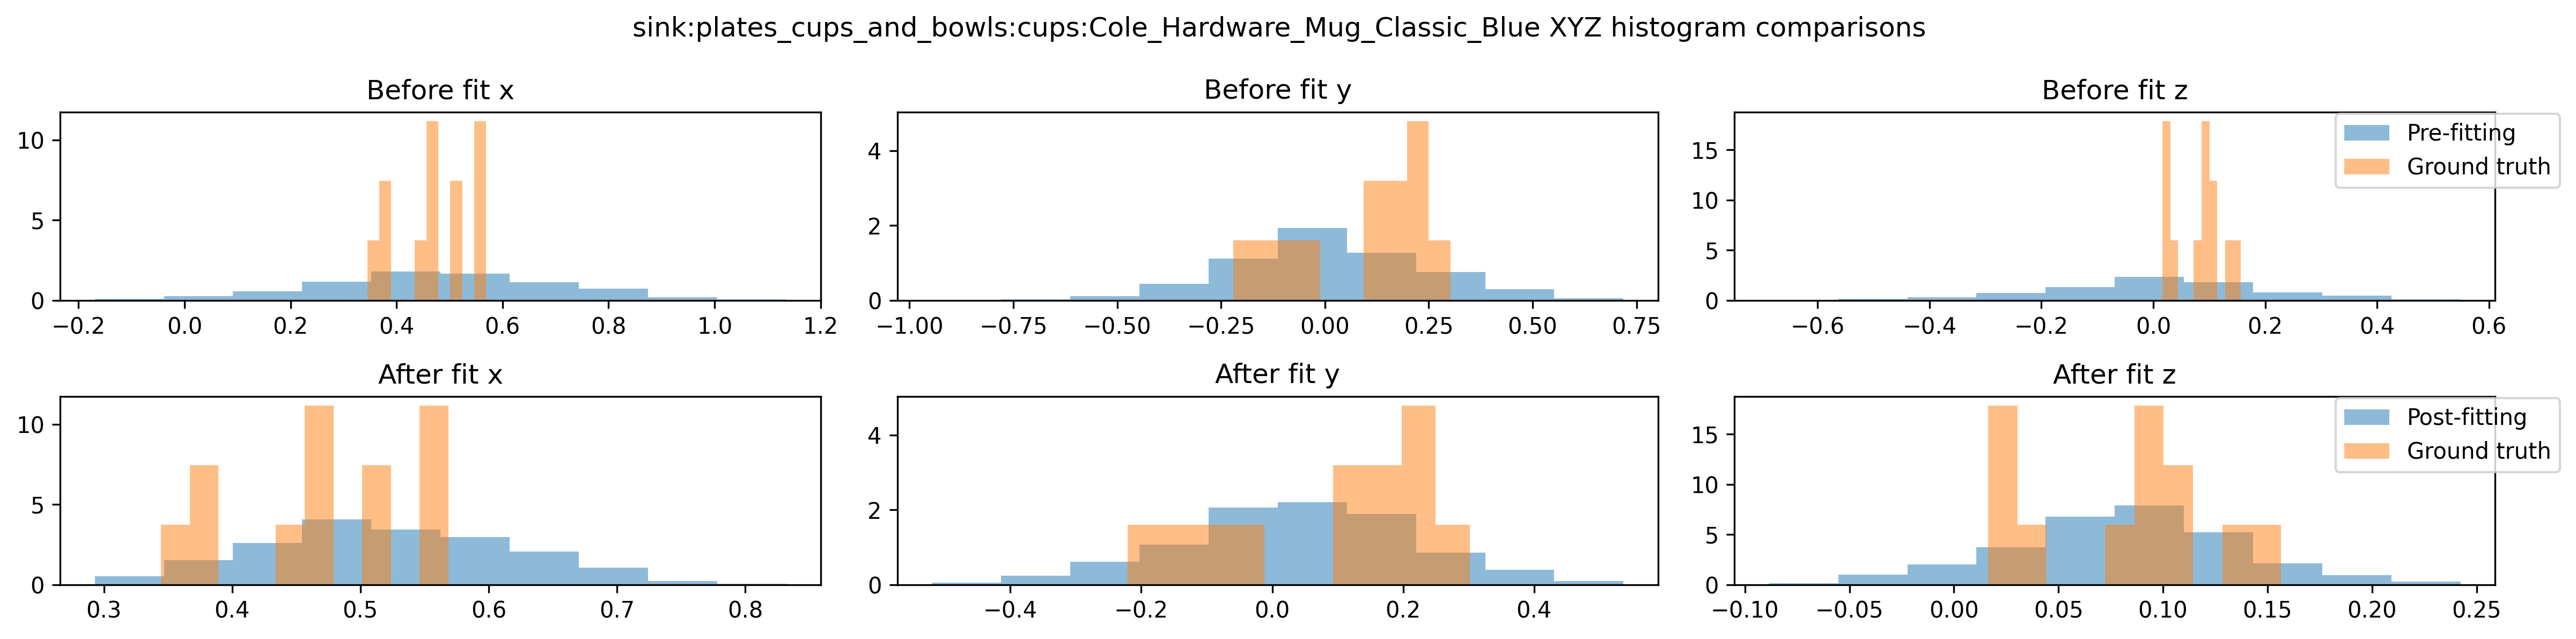

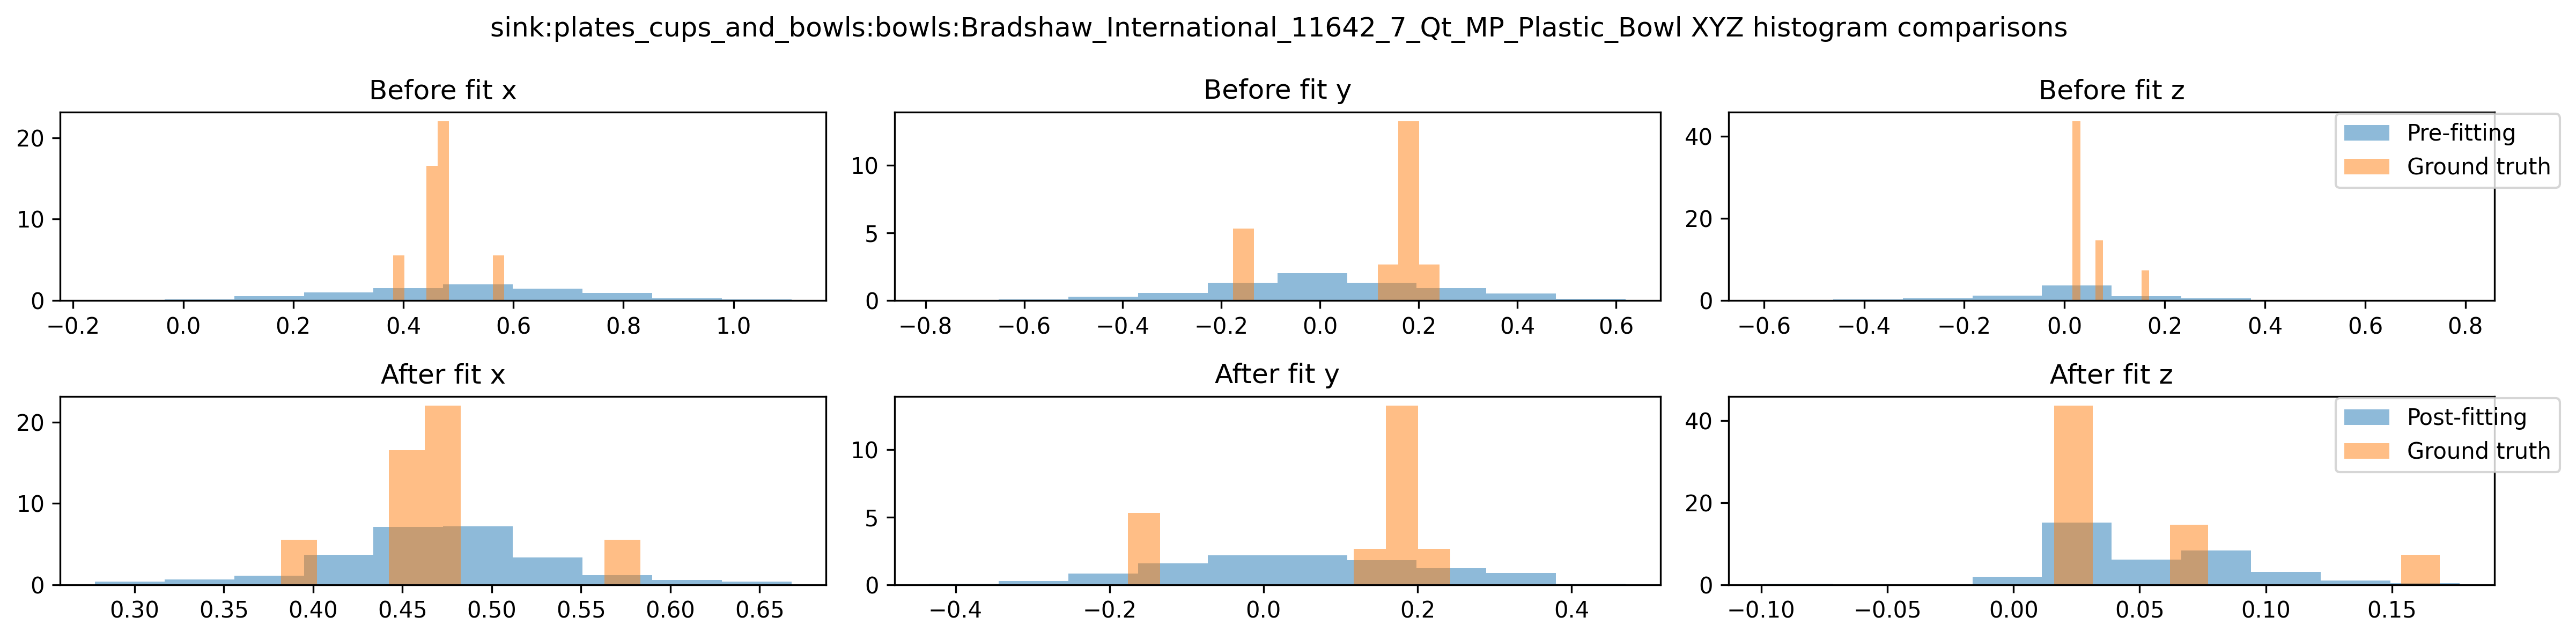

In [13]:
def get_all_node_xyzs(sampled_trees, node_type):
    l = []
    for tree in sampled_trees:
        for node in tree:
            if isinstance(node, node_type):
                l.append(node.translation.detach().cpu().numpy())
    return np.stack(l)
def plot_post_fit_tree_samples(em, N_samples=100):
    pre_fit_samples= []
    em.grammar.load_state_dict(em.grammar_iters[0])
    for k in range(N_samples):
        pre_fit_samples.append(em.grammar.sample_tree(detach=True))
    fit_samples = []
    em.grammar.load_state_dict(em.grammar_iters[-1])
    for k in range(N_samples):
        fit_samples.append(em.grammar.sample_tree(detach=True))

    for node_type in [PlateModels[0], CupModels[0], BowlModels[0]]:
        plt.figure(dpi=300).set_size_inches(16, 4)
        plt.suptitle("%s XYZ histogram comparisons" % node_type.__name__)

        gt_l = get_all_node_xyzs([SceneTree.make_from_observed_nodes(sample) for sample in observed_node_sets], node_type)
        fit_l = get_all_node_xyzs([sample for sample in fit_samples], node_type)
        pre_fit_l = get_all_node_xyzs([sample for sample in pre_fit_samples], node_type)
        # Pre fit
        for k in range(3):
            plt.subplot(2, 3, k+1)
            plt.title("Before fit %s" % "xyz"[k:(k+1)])
            plt.hist(pre_fit_l[:, k], label="Pre-fitting", alpha=0.5, density=True)
            plt.hist(gt_l[:, k], label="Ground truth", alpha=0.5, density=True)
            if k == 2:
                plt.legend(bbox_to_anchor=(1.1, 1.05))

        for k in range(3):
            plt.subplot(2, 3, k+1+3)
            plt.title("After fit %s" % "xyz"[k:(k+1)])
            plt.hist(fit_l[:, k], label="Post-fitting", alpha=0.5, density=True)
            plt.hist(gt_l[:, k], label="Ground truth", alpha=0.5, density=True)
            if k == 2:
                plt.legend(bbox_to_anchor=(1.1, 1.05))
        plt.tight_layout()
plot_post_fit_tree_samples(em, N_samples=1000)

In [14]:
# Draw some samples from the fit posterior
vis["fit_samples"].delete()
for k in range(5):
    tree = grammar.sample_tree(detach=True)
    draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="fit_samples/%d/contents" % k)
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="fit_samples/%d/structure" % k)

# Test parsing a scene

In [15]:
# Set up grammar
grammar = SpatialSceneGrammar(
    root_node_type = DishBin,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.5, 0., 0.]))
)
grammar.load_state_dict(torch.load("fit_grammar.torch"))

<All keys matched successfully>

In [16]:
# Parse that dummy observation; it should have only one unique parse, since there's only one
# object.
results = infer_mle_tree_with_mip(grammar, observed_node_sets[1], N_solutions=5, max_recursion_depth=10, verbose=True)
trees = get_optimized_trees_from_mip_results(results)
vis["parses"].delete()
for k, tree in enumerate(trees):
    if k == 0:
        draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="parses/contents/%d" % k)
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="parses/structure/%d" % k)
    print("Computed score %f, optimization score %f" % (tree.score(verbose=0), results.optim_result.get_suboptimal_objective(k)))

Starting setup.
Activation vars allocated.
Continuous variables allocated.
Setup time:  0.4370126724243164
Num vars:  3011
Num constraints:  6395
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Fri Oct  1 01:23:26 2021

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 4210 rows, 3011 columns and 17816 nonzeros
Model fingerprint: 0x91a91920
Model has 213 quadratic objective terms
Variable types: 2754 continuous, 257 integer (257 binary)
Coefficient statistics:
  Matrix range     [9e-03, 5e+05]
  Objective range  [2e-01, 3e+04]
  QObjective range [3e+01, 2e+06]
  Bounds range     [1e-01, 1e+00]
  RHS range        [2e-15, 1e+01]
Presolve removed 3402 rows and 2320 columns
Presolve time: 0.02s
Presolved: 808 rows, 691 columns, 3606 nonzeros
Presolved model has 132 quadratic objective terms
Variable types: 680 continuous, 11 integer (11 binary)

Root relaxation: objective -5.258473e+02, 1506 iterations, 0.01 seconds

    Nodes    